In [2]:
import cPickle, pupil
from pylab import *
import seaborn as sns
import patsy_transforms as pt
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('ticks')
data = cPickle.load(open('s02.pickle'))
events, messages = data['events'], data['messages']
events = events.reset_index()
del events['level_0']
del events['level_1']
events.rename(columns={'level_2':'sample_time'}, inplace=True)
events.sample_time = events.sample_time.astype(int)
events.set_index(['session', 'block', 'sample_time'], inplace=True)
messages.feedback.ix[messages.feedback==0] = -1

/Users/nwilming/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:
events = events.loc[(3,slice(None), slice(None))]
messages = messages.loc[(3,slice(None), slice(None))]

(0, 150)

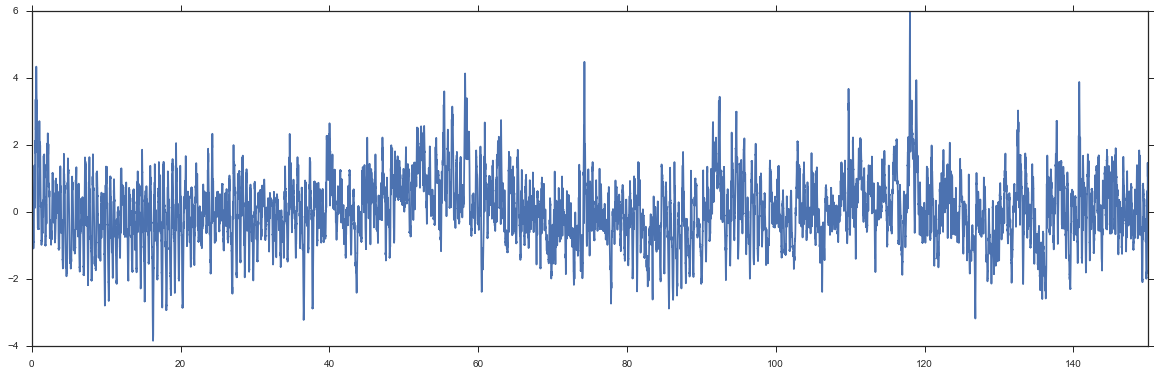

In [21]:
figure(figsize=(20, 6))
plot(arange(len(pa))/1000., events.pa)
xlim([0, 150])

In [42]:
events, messages = pupil.prepare_glm_regressors(events, messages)


In [11]:
low, pa , above = pupil.filter_pupil(events.pa, 100, highcut=100, lowcut=0.001)
figure(figsize=(20, 6))
plot(pa+above)
xlim([50000, 70000])
events['pafilt'] = pa

ValueError: Digital filter critical frequencies must be 0 <= Wn <= 1

In [43]:
events.columns

Index([u'blink', u'left_gx', u'left_gy', u'pa', u'right_gx', u'right_gy',
       u'start', u'time', u'trial', u'decision', u'feedback', u'pafilt',
       u'palow', u'pahigh', u'contrast', u'subject', u'ref', u'decramp',
       u'decramp2', u'dec_start', u'decramp21', u'decramp22', u'decramp23',
       u'decramp24', u'decision21', u'decision22', u'decision23',
       u'decision24', u'feedback_offset_neg', u'feedback_offset_pos',
       u'decend', u'yhat', u'residuals', u'decstart21', u'decstart22',
       u'decstart23', u'decstart24'],
      dtype='object')

In [44]:
events['decend'] = events.decision>0
length = 300
df = 10
m, yh, y, X, res = pupil.eval_model('''
pafilt ~   
     pt.Z(left_gx) + pt.Z(left_gy) +
     pt.BS(pt.Z(left_gx), df={df}, length={len}) + 
     pt.BS(pt.Z(left_gy), df={df}, length={len}) + 
     pt.BS(blink, df={df}, length={len}) +
     pt.BS(pt.Z(pt.dt(left_gx)), df={df}, length={len}) + 
     pt.BS(pt.Z(pt.dt(left_gy)), df={df}, length={len}) +
     
     pt.BS(ref, df={df}, length={len}) +  
     pt.BS(contrast, df={df}, length={len}) +
     pt.BS(pt.Z(pt.dt(contrast)), df={df}, length={len}) +     
     
     pt.BS(decstart21, df={df}, length={len}) + 
     pt.BS(decstart22, df={df}, length={len}) +
     pt.BS(decstart23, df={df}, length={len}) +
     pt.BS(decstart24, df={df}, length={len}) +
     pt.BS(decend, df={df}, length={len}) + 
     
     pt.BS(feedback_offset_pos, df={df}, length={len}) +
     pt.BS(feedback_offset_neg, df={df}, length={len})

     
'''.format(len=length, df=df), events.reset_index())
print X.shape
print yh.shape
events['yhat'] = yh
events['residuals'] = y-yh

# Halde
_= '''
     pt.BS(decision21, df={df}, length={len}) +
     pt.BS(decision22, df={df}, length={len}) +
     pt.BS(decision23, df={df}, length={len}) +
     pt.BS(decision24, df={df}, length={len}) +
     pt.BS(dec_start, df={df}, length={len}) +
     pt.BS(decend, df={df}, length={len}) +  
     pt.BS(decramp21, df={df}, length={len}) + 
     pt.BS(decramp22, df={df}, length={len}) +
     pt.BS(decramp23, df={df}, length={len}) +
     pt.BS(decramp24, df={df}, length={len}) +
'''

R**2: 0.476509613983
(272477, 153)
(272477, 1)


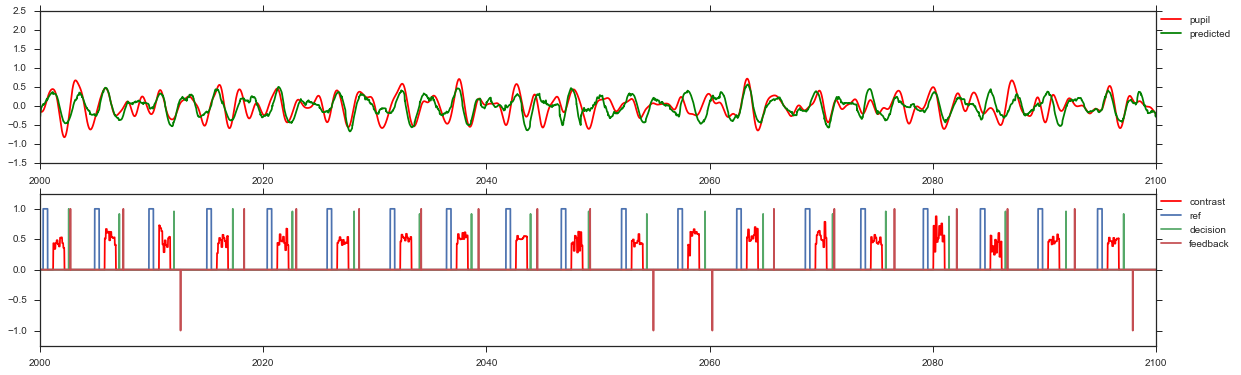

In [21]:
import glm_viz
figure(figsize=(20, 6))
glm_viz.timecourse(events, y, yh, [2000, 2100])

In [9]:
messages['contrast_onset_time'] = [x.contrast_time[0] for _,x in messages.iterrows()]
messages['reference_onset_time'] = [x.decision_time-1900 for _, x in messages.iterrows()]


/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/nwilming/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


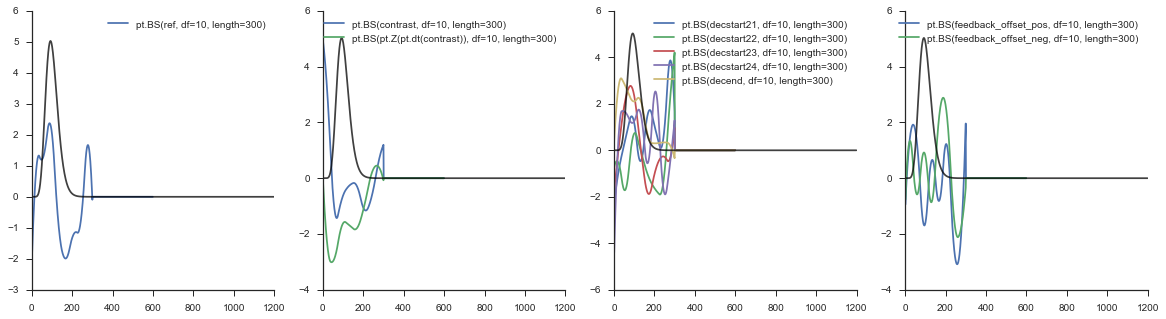

In [46]:
figure(figsize=(20,5))
glm_viz.plot_kernels(['ref', 'contrast', 'dec', 'feedback'], res, X, length, df)

Skipping one event because not enough data
262 340
Skipping one event because not enough data
164 340


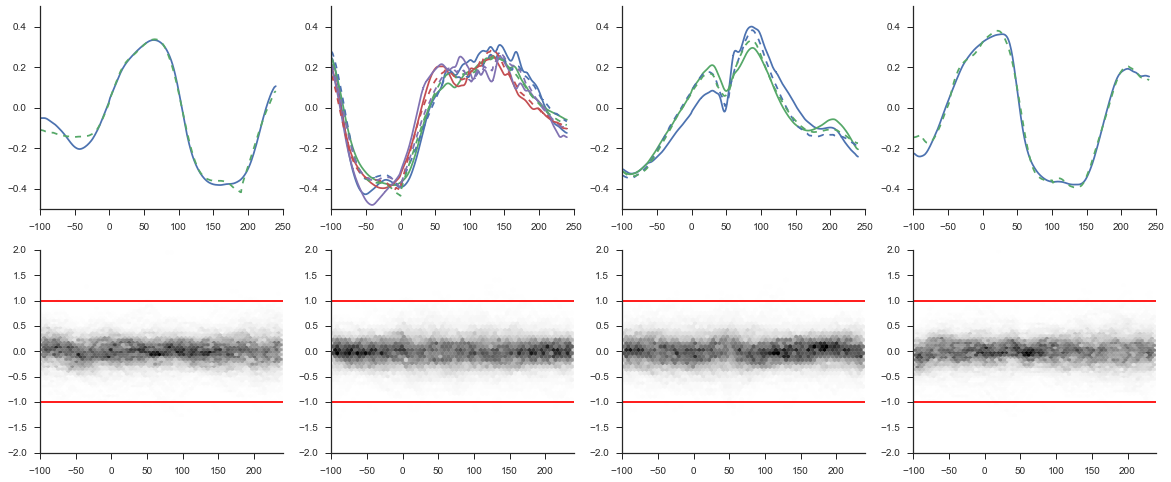

In [47]:
figure(figsize=(20,8))
glm_viz.condition_averages(events, messages)